In [7]:
import k3d
import numpy as np
from bmcs_shell.folding.assembly.wb_scanned_cell import WBScannedCell
from bmcs_shell.api import WBTessellation4PEx
from scipy.spatial import cKDTree
import pandas as pd
from openpyxl import load_workbook

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
import k3d
import numpy as np
from bmcs_shell.folding.assembly.wb_scanned_cell import WBScannedCell
from bmcs_shell.api import WBTessellation4PEx
from scipy.spatial import cKDTree
import pandas as pd
from openpyxl import load_workbook

# Set the reference geometry to be generated from the closed form kinematics

wb_shell = WBTessellation4PEx(
                         a=1000/4,
                         b = 1615/4, 
                         c = 645/4, 
                         e_x = 286/4,
                         gamma=0.683, # a value of gamma = 0.75 was estimated from normals, but a CAD comparison showed that 0.75 doesn't lead to closer geometry to the scanned 
                         n_phi_plus=2, # planned 5 
                         n_x_plus=2,  # planned 3
                         wireframe_width=5,
                        ##---- Trimming function works only in WBTessellation4P ----##
                         trim_half_cells_along_y=True,
                         trim_half_cells_along_x=True,
#                          align_outer_nodes_along_x=True,
)
# wb_shell.interact()
orig_I_Fi = np.copy(wb_shell.I_Fi_trimmed)
orig_X_Ia = np.copy(wb_shell.X_Ia_trimmed)

# Define the instance cell of the WBScannedCell class

modules = {'WB305': ('WB305_facets_points.obj', [[1, 0], [np.pi/2, np.pi/2]]),
            'WB306': ('WB306_facets_points.obj', [[1, 0], [np.pi/2, -np.pi/2]]),
            'WB307': ('WB307_facets_points.obj', [[1], [np.pi/2]]),
            'WB308': ('WB308_facets_points.obj', [[1, 2], [np.pi/2, np.pi]]),
            'WB309': ('WB309_facets_points.obj', [[0, 2], [np.pi/2, -np.pi/2]]),
            'WB310': ('WB310_facets_points.obj', [[1, 2], [np.pi/2, np.pi]]),
            'WB311': ('WB311_facets_points.obj', [[1], [np.pi/2]]),
            'WB312': ('WB312_facets_points.obj', [[1], [-np.pi/2]])
            }




def calculate_normal(vertices):
    """
    Calculate the normal of a triangle or quadrilateral facet.
    """
    if len(vertices) == 3:  # Triangle
        v1, v2, v3 = vertices
        vec1 = v2 - v1
        vec2 = v3 - v1
        normal = np.cross(vec1, vec2)
    elif len(vertices) == 4:  # Quadrilateral
        v1, v2, v3, v4 = vertices
        vec1 = v2 - v1
        vec2 = v4 - v1
        vec3 = v3 - v2
        normal1 = np.cross(vec1, vec2)
        normal2 = np.cross(vec3, vec1)
        normal = (normal1 + normal2) / 2  # Average the normals
    else:
        raise ValueError("Facet must have 3 (triangle) or 4 (quadrilateral) vertices.")
    
    unit_normal_vector = normal / np.linalg.norm(normal)
    return   unit_normal_vector# Normalize the vector

def calculate_angle(normal1, normal2):
    """
    Calculate the angle (in degrees) between two normal vectors.
    """
    cos_theta = np.clip(np.dot(normal1, normal2), -1.0, 1.0)
    angle_radians = np.arccos(cos_theta)
    angle_degrees = np.degrees(angle_radians)
    
    # Compute the rotation axis
    rotation_axis = np.cross(normal1, normal2)
    rotation_direction = {
        'x': 'clockwise' if rotation_axis[0] < 0 else 'counterclockwise',
        'y': 'clockwise' if rotation_axis[1] < 0 else 'counterclockwise',
        'z': 'clockwise' if rotation_axis[2] < 0 else 'counterclockwise'
    }
    
    return angle_degrees, rotation_direction

def calculate_normals_and_angle(facets_N_OS, orig_points, scan_points):
    # Create a DataFrame to store the results
    results = []
    
    for i in range(0, len(facets_N_OS)):
        facet_orig_coord = orig_points[facets_N_OS[i]]
        facet_scan_coord = scan_points[facets_N_OS[i]]
        
        # Calculate normals for original and scanned facets
        n_orig = calculate_normal(facet_orig_coord)
        n_scan = calculate_normal(facet_scan_coord)
        print(f"Facet {i}: Scanned normal: {n_scan}")

        # Calculate the angle and rotation direction
        angle, rotation_direction = calculate_angle(n_orig, n_scan)
        
        # Add the result to the DataFrame
        results.append({
            'Facet': i,
            'Angle between normals (degrees)': angle,
            'Coord: normal vector scan': n_scan
        })
    
    # Create the DataFrame from the results list
    df_normals = pd.DataFrame(results)
    return df_normals

def define_facets():
    """Define the list with the facet nodes."""
    return [
        [15, 13, 14], [6, 14, 12], [6, 2, 10],
        [0, 2, 3, 1], [1, 3, 7], [7, 3, 8],
        [8, 9, 10], [10, 12, 11], [7, 11, 5],
        [7, 5, 1], [1, 5, 4, 0], [0, 4, 6],
        [6, 4, 17], [17, 16, 15]
    ]

def initialize_kdtree(scan_points):
    """Initialize a KDTree for the scan points."""
    return cKDTree(scan_points)

def compute_nearest_neighbors(tree, orig_points):
    """Find the nearest neighbors in the scan for each point in the original geometry."""
    distances, indices = tree.query(orig_points)
    return distances, indices

def create_differences_dataframe(orig_points, scan_points, scan_indices, distances):
    """Create a DataFrame containing differences and distances for points."""
    diffs = scan_points - orig_points
    columns = [
        "orig_index", "scan_index", "orig_x", "orig_y", "orig_z",
        "scan_x", "scan_y", "scan_z", "delta_x", "delta_y", "delta_z", "euclidean_distance"
    ]
    df_nodes = pd.DataFrame(columns=columns)
    for i in range(len(orig_points)):
        df_nodes.loc[i] = [
            i,                           # orig_index
            scan_indices[i],             # scan_index
            *orig_points[i],             # orig_x, orig_y, orig_z
            *scan_points[i],             # scan_x, scan_y, scan_z
            *diffs[i],                   # delta_x, delta_y, delta_z
            distances[i]                 # euclidean_distance
        ]
    return df_nodes

def save_dataframe_to_excel(df, filename):
    """Save a DataFrame to an Excel file."""
    df.to_excel(filename, index=False, engine='openpyxl')

def compute_statistics(aggregated_data):
    """Compute statistical metrics for each node."""
    stats_data = []
    for node_index, data in aggregated_data.items():
        stats = {
            'node_index': node_index,
            'mean_delta_x': np.mean(data['delta_x']),
            'mean_delta_y': np.mean(data['delta_y']),
            'mean_delta_z': np.mean(data['delta_z']),
            'mean_distance': np.mean(data['euclidean_distance']),
            'std_delta_x': np.std(data['delta_x']),
            'std_delta_y': np.std(data['delta_y']),
            'std_delta_z': np.std(data['delta_z']),
            'std_distance': np.std(data['euclidean_distance']),
            'cov_delta_x': np.std(data['delta_x']) / np.mean(data['delta_x']) if np.mean(data['delta_x']) != 0 else 0,
            'cov_delta_y': np.std(data['delta_y']) / np.mean(data['delta_y']) if np.mean(data['delta_y']) != 0 else 0,
            'cov_delta_z': np.std(data['delta_z']) / np.mean(data['delta_z']) if np.mean(data['delta_z']) != 0 else 0,
            'cov_distance': np.std(data['euclidean_distance']) / np.mean(data['euclidean_distance']) if np.mean(data['euclidean_distance']) != 0 else 0,
            'quantile_5_delta_x': np.percentile(data['delta_x'], 5),
            'quantile_5_delta_y': np.percentile(data['delta_y'], 5),
            'quantile_5_delta_z': np.percentile(data['delta_z'], 5),
            'quantile_5_distance': np.percentile(data['euclidean_distance'], 5),
            'quantile_95_delta_x': np.percentile(data['delta_x'], 95),
            'quantile_95_delta_y': np.percentile(data['delta_y'], 95),
            'quantile_95_delta_z': np.percentile(data['delta_z'], 95),
            'quantile_95_distance': np.percentile(data['euclidean_distance'], 95),
        }
        stats_data.append(stats)
    return pd.DataFrame(stats_data)

def calculate_statistics_from_dict(data_dict, key_name):
    """
    Calculate statistics for each entry in a dictionary and return a DataFrame.

    Parameters:
        data_dict (dict): Dictionary with entries containing lists of numerical values.

    Returns:
        pd.DataFrame: DataFrame with statistics (mean, std, 5% quantile, 95% quantile) for each key.
    """
    # Initialize a list to store results
    results = []

    # Iterate through each key-value pair in the dictionary
    for key, metrics in data_dict.items():
        for metric_name, values in metrics.items():
            # Calculate statistics
            mean_val = np.mean(values)
            std_val = np.std(values)
            quantile_5_val = np.percentile(values, 5)
            quantile_95_val = np.percentile(values, 95)

            # Append the results as a dictionary
            results.append({
                key_name: key,
                "metric": metric_name,
                f"{metric_name}_mean": mean_val,
                f"{metric_name}_std": std_val,
                f"{metric_name}_quantile_5": quantile_5_val,
                f"{metric_name}_quantile_95": quantile_95_val,
            })

    # Convert the results into a DataFrame
    return pd.DataFrame(results)

def calculate_statistics_from_dict(data_dict, key_name):
    """
    Calculate statistics for each entry in a dictionary and return a DataFrame.

    Parameters:
        data_dict (dict): Dictionary with entries containing lists of numerical values.

    Returns:
        pd.DataFrame: DataFrame with statistics (mean, std, 5% quantile, 95% quantile) for each key.
    """
    # Initialize a list to store results
    results = []

    # Iterate through each key-value pair in the dictionary
    for key, metrics in data_dict.items():
        for metric_name, values in metrics.items():
            # Calculate statistics
            mean_val = np.mean(values)
            std_val = np.std(values)
            quantile_5_val = np.percentile(values, 5)
            quantile_95_val = np.percentile(values, 95)

            # Append the results as a dictionary
            results.append({
                key_name: key,
                "metric": metric_name,
                f"{metric_name}_mean": mean_val,
                f"{metric_name}_std": std_val,
                f"{metric_name}_quantile_5": quantile_5_val,
                f"{metric_name}_quantile_95": quantile_95_val,
            })

    # Convert the results into a DataFrame
    return pd.DataFrame(results)

def analysis_scan_orig_geometry(modules, orig_X_Ia):
    """Analyze the geometry by comparing scan data with the original geometry."""
    facets_N_OS = define_facets()
    aggregated_nodes = {}
    aggregated_normals = {}

    for module_id, (file_name, axes_angles) in modules.items():
        cell = WBScannedCell(file_path=file_name, rotate_system=[axes_angles[0], axes_angles[1]])
        tree = initialize_kdtree(cell.O_crease_nodes_X_Na)
        distances, scan_indices = compute_nearest_neighbors(tree, orig_X_Ia)
        scan_X_Ia = cell.O_crease_nodes_X_Na[scan_indices]

        df_nodes = create_differences_dataframe(orig_X_Ia, scan_X_Ia, scan_indices, distances)
        save_dataframe_to_excel(df_nodes, f"WBScanCell_Nodes_Evaluation_{module_id}.xlsx")

        # Calculate normals, angles, and rotation directions
        df_normals = calculate_normals_and_angle(facets_N_OS, orig_X_Ia, scan_X_Ia)
        save_dataframe_to_excel(df_normals, f"WBScanCell_Normals_Evaluation_{module_id}.xlsx")
        print(f"WBScanCell_Normals_Evaluation_{module_id}.xlsx saved.")
        
        # Aggregate index of the crease nodes for statistics
        for i in range(len(orig_X_Ia)):
            if i not in aggregated_nodes:
                aggregated_nodes[i] = {
                    'delta_x': [], 'delta_y': [], 'delta_z': [],
                    'euclidean_distance': []
                }
            aggregated_nodes[i]['delta_x'].append(scan_X_Ia[i, 0] - orig_X_Ia[i, 0])
            aggregated_nodes[i]['delta_y'].append(scan_X_Ia[i, 1] - orig_X_Ia[i, 1])
            aggregated_nodes[i]['delta_z'].append(scan_X_Ia[i, 2] - orig_X_Ia[i, 2])
            aggregated_nodes[i]['euclidean_distance'].append(distances[i])
            
        # Aggregate index of the facets for statistics
        for i in range(len(facets_N_OS)):
            if i not in aggregated_normals:
                aggregated_normals[i] = {
                    'angle_between_normals': [] 
                }
            aggregated_normals[i]['angle_between_normals'].append(df_normals.iloc[i, 1])

    df_nodes_stats = compute_statistics(aggregated_nodes)
    save_dataframe_to_excel(df_nodes_stats, "WBScanCell_Nodes_Statistics.xlsx")
    
    df_normals_stats = calculate_statistics_from_dict(aggregated_normals, key_name="facet_index")
    save_dataframe_to_excel(df_normals_stats, "WBScanCell_Normals_Statistics.xlsx")

    

    return cell, scan_X_Ia, df_nodes, df_nodes_stats, df_normals, df_normals_stats

cell, scan_X_Ia, df_nodes, df_nodes_stats, df_normals, df_normals_stats = analysis_scan_orig_geometry(modules, orig_X_Ia)
df_normals_stats


Facet 0: Scanned normal: [0.         0.32126117 0.94699063]
Facet 1: Scanned normal: [-0.43682036  0.52375887  0.7313444 ]
Facet 2: Scanned normal: [-0.00179395  0.01752325  0.99984485]
Facet 3: Scanned normal: [-0.00124692  0.28056321 -0.95983474]
Facet 4: Scanned normal: [0.71968397 0.28546058 0.63290382]
Facet 5: Scanned normal: [-0.73138087 -0.26632338  0.62781676]
Facet 6: Scanned normal: [0.         0.31553787 0.94891298]
Facet 7: Scanned normal: [ 0.         -0.30856319  0.95120385]
Facet 8: Scanned normal: [-0.72389606  0.25239499  0.64208353]
Facet 9: Scanned normal: [ 0.72543151 -0.27526146  0.63085676]
Facet 10: Scanned normal: [ 0.00125139 -0.28042141 -0.95987617]
Facet 11: Scanned normal: [-0.71713305 -0.28467602  0.63614444]
Facet 12: Scanned normal: [0.70126719 0.25677996 0.66504765]
Facet 13: Scanned normal: [ 0.         -0.30462137  0.95247353]
WBScanCell_Normals_Evaluation_WB305.xlsx saved.
Facet 0: Scanned normal: [0.         0.31802023 0.94808393]
Facet 1: Scanned n

,facet_index,metric,angle_between_normals_mean,angle_between_normals_std,angle_between_normals_quantile_5,angle_between_normals_quantile_95
0,0,angle_between_normals,0.262736,0.104976,0.112522,0.397790
1,1,angle_between_normals,1.398120,0.223654,1.090769,1.699334
2,2,angle_between_normals,0.215897,0.088709,0.100214,0.351482
3,3,angle_between_normals,0.671905,0.100610,0.577006,0.817446
4,4,angle_between_normals,1.748958,0.368059,1.174231,2.140923
5,5,angle_between_normals,0.725855,0.316416,0.237637,1.101948
6,6,angle_between_normals,0.562715,0.097958,0.437059,0.710676
7,7,angle_between_normals,1.038660,0.193446,0.854375,1.373157
8,8,angle_between_normals,1.798667,0.633285,0.716228,2.488238
9,9,angle_between_normals,1.794297,0.359128,1.222948,2.184579


In [2]:
df_normals

,Facet,Angle between normals (degrees),Coord: normal vector scan
0,0,0.133373,"[0.0, 0.3227638866999423, 0.9464795155957401]"
1,1,1.611874,"[-0.4369078105818623, 0.5213628542871005, 0.73..."
2,2,0.326708,"[-0.0053118611982849616, 0.018114233126369648,..."
3,3,0.785876,"[-0.0006915658312114973, 0.2813423194108464, -..."
4,4,2.087626,"[0.7192845844243557, 0.28914187444426726, 0.63..."
5,5,0.226102,"[-0.7397360374479952, -0.2727395323406842, 0.6..."
6,6,0.460967,"[0.0, 0.3173470634875167, 0.9483094649405595]"
7,7,1.499800,"[0.0, -0.3001020052142537, 0.9539071162678179]"
8,8,2.038755,"[-0.7257865507755131, 0.25637796983781214, 0.6..."
9,9,2.211307,"[0.7257629487597564, -0.27321058656435, 0.6313..."


In [3]:
def plot_mean_error(node_indices, mean_distances, std_distances, x_label, y_label, legend_label, color_index, plot_name):
    """
    Create a plot with error bars showing the mean and standard deviation of distances.
    
    Parameters:
        node_indices (np.ndarray): Array of node indices.
        mean_distances (np.ndarray): Array of mean distances.
        std_distances (np.ndarray): Array of standard deviations of distances.
    """

    # Importing necessary libraries
    import matplotlib.pyplot as plt
    from matplotlib import rcParams
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np

    # Define global style settings
    rcParams['font.family'] = 'Arial'
    rcParams['mathtext.fontset'] = 'stix'  # Use Times font for math
    rcParams['mathtext.rm'] = 'Arial'  # Set Times for regular math text

    colors = [
        '#00549f',  # 0: dark_blue
        '#407fb7',  # 1: medium_blue
        '#8ebae5',  # 2: light_blue
        '#c7ddf2',  # 3: sky_blue
        '#e8f1fa',  # 4: very_light_blue
        '#57ab27',  # 5: (green)
        '#8dc060',  # 6: (light green)
        '#b8d698',  # 7: (pale green)
        '#ddebce',  # 8: (very pale green)
        '#f2f7ec',   # 9: (almost white)
        '#cc071e',  # 10: (deep red)
        '#d85c41',  # 11: (red orange)
        '#e69679',  # 12: (light red orange)
        '#f3cdbb',  # 13: (pale red orange)
        '#faebe3',  # 14: (very pale red)
        
    ]
    # Set figure size (half A4 width)
    fig = plt.figure(figsize=(14 / 2.54, 8 / 2.54))  # Convert cm to inches
    ax = plt.gca()  # Get current axis
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Plot with error bars
    plt.errorbar(
        node_indices, mean_distances, yerr=std_distances, 
        fmt='o', color=colors[color_index], ecolor='black', elinewidth=0.5, capsize=3, label=legend_label
    )

    # Customize plot
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    plt.xticks(node_indices, fontsize=14)
    plt.yticks(fontsize=14)
    #plt.legend(loc='best', fontsize=14)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Show plot
    plt.tight_layout()
    plt.savefig(plot_name+'.png', dpi=300)
    plt.savefig(plot_name+'.pdf', dpi=300)
    plt.savefig(plot_name+'.svg', dpi=300)
    #plt.show()


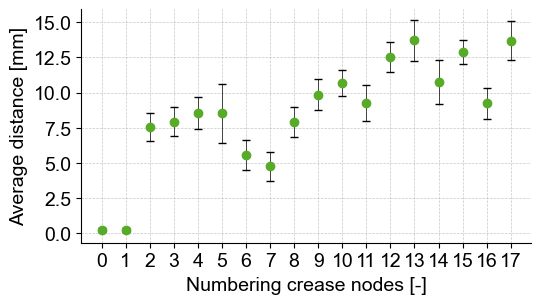

In [4]:
df = pd.read_excel('WBScanCell_Nodes_Statistics.xlsx')
# Example data
node_indices = df['node_index'].values # Node indices
mean_distances = df['mean_distance'].values # Mean distances
std_distances = df['std_distance'].values # Standard deviations of distances
plot_mean_error(node_indices, mean_distances, std_distances, 'Numbering crease nodes [-]', 'Average distance [mm]', 'Average distance and standard deviation', 5, 'statistical_analysis_nodes')


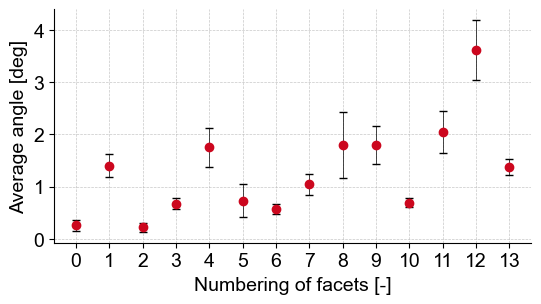

In [5]:
df = pd.read_excel('WBScanCell_Normals_Statistics.xlsx')
# Example data
node_indices = df['facet_index'].values # Node indices
mean_distances = df['angle_between_normals_mean'].values # Mean distances
std_distances = df['angle_between_normals_std'].values # Standard deviations of distances
plot_mean_error(node_indices, mean_distances, std_distances, 'Numbering of facets [-]', "Average angle [deg]", 'Average angle and standard deviation', 10, 'statistical_analysis_facets')

In [6]:
plot = k3d.plot(name='Vectors')
cell.plot_O_crease_lines(plot, line_numbers=False)
cell.plot_O_basis(plot)
cell.plot_points(plot, orig_X_Ia, point_size=25, color=0x0000ff, plot_numbers=True)
cell.plot_points(plot, scan_X_Ia, point_size=25, color=0x007777, plot_numbers=True)

/Users/gui/Documents/VSCode/bmcs_env/lib/python3.12/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…